# Verification

This notebook is used to verify the correctness of the solution.

It contains verifications of the following cases:



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import io
import zipfile
from geopy.distance import geodesic
from pathlib import Path
from examples.example_code import load_SAtlas_Solar_Classification_Data
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from examples.example_code import load_Energistyrelsen_data
import folium
import pandas as pd
import pandas as pd
import geopandas as gpd
from tqdm import tqdm

from typing import List
from src.dynamic_world import DynamicWorldBasemap
import ee

from config import DK_AREA_MAPPING, EXAMPLE_ASSETS

from src.utils import enforce_epsg
from config import EPSG_MAPPING
import geopandas as gpd
from tqdm import tqdm
from config import DK_ISLAND_SIZES

from shapely.geometry import Point

/Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Size Evaluations

## Inspection of the Danish island Rømø

In [2]:
# Shape of Rømø according to LSIB
from src.data.marius import chip_from_db
from src.dynamic_world import DynamicWorldBasemap
from shapely.geometry import Polygon
import geopandas as gpd
from shapely.geometry import Polygon
from src.utils import enforce_epsg

### LSIB Shape
dwb = DynamicWorldBasemap(area_name="Denmark", date_ranges=["2017-01-01", "2017-12-31"])
denmark_coords, denmark_geometry = dwb.get_country_LSIB_coordinates("Denmark")

list_of_coordinates_for_romo = denmark_coords[1][0]

gdf = gpd.GeoDataFrame(
    geometry=[Polygon(list_of_coordinates_for_romo)], crs=EPSG_MAPPING["Plotting"]
)
size_according_to_lsib: float = (
    enforce_epsg(gdf, EPSG_MAPPING["Denmark"]).area.values[0] / 10**6
)

### Dynamic World Classifications
chip = chip_from_db(years=["2017", "2017"], sub_areaID="1")
chip = enforce_epsg(chip, EPSG=EPSG_MAPPING["Denmark"])
dissolved = chip.dissolve(by="year")
size_according_to_dynamic_world: float = dissolved.area.values[0] / 10**6

Initializing Earth Engine with Viktor's project
['13_8_5']


In [3]:
print(f"Size of Rømø according to LSIB: {size_according_to_lsib:.2f} km^2")
print(
    f"Size of Rømø according to Dynamic World: {size_according_to_dynamic_world:.2f} km^2"
)

Size of Rømø according to LSIB: 87.74 km^2
Size of Rømø according to Dynamic World: 62.26 km^2


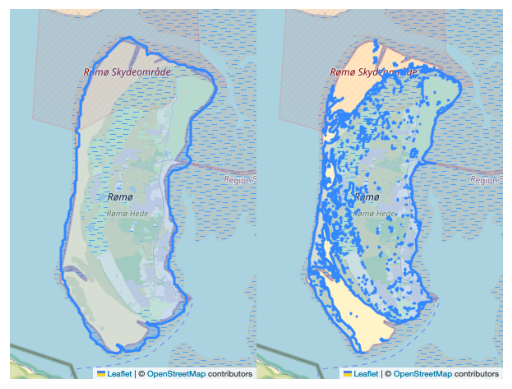

In [4]:
# Plot gdf in folium
from config import EXAMPLE_ASSETS
import io
from PIL import Image

# centroid of romo
dissolved = dissolved.to_crs(EPSG_MAPPING["Plotting"])
centroid: Point = dissolved.centroid.values[0]

# LSIB Plotting
outpath_LSIB = EXAMPLE_ASSETS / f"romo_LSIB_2017_{size_according_to_lsib:.0f}km.png"
gdf = gdf.to_crs(EPSG_MAPPING["Plotting"])

# define m with centroid as location

m = folium.Map(
    location=[centroid.y, centroid.x],
    zoom_start=11,
    png_enabled=True,
    height=450,
    width=300,
    zoom_control=False,
)

folium.GeoJson(gdf).add_to(m)

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save(outpath_LSIB)

# Dynamic World Plotting
outpath_DW = (
    EXAMPLE_ASSETS
    / f"romo_dynamic_world_2017_{size_according_to_dynamic_world:.0f}km.png"
)
dissolved = dissolved.to_crs(EPSG_MAPPING["Plotting"])

# define m with centroid as location
m = folium.Map(
    location=[centroid.y, centroid.x],
    zoom_start=11,
    png_enabled=True,
    height=450,
    width=300,
    zoom_control=False,
)

folium.GeoJson(dissolved).add_to(m)

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img.save(outpath_DW)

# Display outpath_DW and outpath_LSIB pngs next to each other
from PIL import Image
import matplotlib.pyplot as plt

# Open the images
img1 = Image.open(outpath_LSIB)
img2 = Image.open(outpath_DW)

# Create a new image with twice the width of the two images
new_img = Image.new("RGB", (img1.width + img2.width, img1.height))
new_img.paste(img1, (0, 0))
new_img.paste(img2, (img1.width, 0))

# Display the image
plt.imshow(new_img)
plt.axis("off")
plt.show()

## Comparison of size of countries according to our analysis compared to LSIB compared to 'official' size

In [10]:
# Size of classified area of each country

from src.DataBaseManager import DBMS
from sqlalchemy import create_engine
import pandas as pd
from config import EPSG_MAPPING
from shapely.geometry import Polygon
from config import COUNTRY_SIZES, TERRESTIAL_COUNTRY_SIZES

country_size_path = EXAMPLE_ASSETS / "country_sizes.csv"
try:
    data = pd.read_csv(country_size_path)

except FileNotFoundError:
    query = """
    SELECT area,year_from,year_to,lulc_category_from,SUM(area_km2) as lulc_area
    FROM land_use_change
    GROUP BY area,year_from,year_to,lulc_category_from
    ORDER BY 
    area,year_from,year_to,SUM(area_km2) desc
    """

    dbms = DBMS()
    dbms.server.start()

    local_port = str(dbms.server.local_bind_port)
    engine = create_engine(
        "postgresql://{}:{}@{}:{}/{}".format(
            dbms.username, dbms.password, "127.0.0.1", local_port, dbms.db_name
        )
    )

    data = pd.read_sql(query, engine)

    data.sort_values(by=["area", "year_from", "year_to"], inplace=True)
    data.drop_duplicates(
        subset=["area", "year_from", "lulc_category_from"], inplace=True, keep="first"
    )

    data = (
        data.groupby(["area", "year_from"])
        .sum()
        .reset_index()
        .drop(columns=["year_to", "lulc_category_from"])
    )

    # fill in the official size of each country
    data["official_size"] = None
    for country, size in COUNTRY_SIZES.items():
        data.loc[data["area"] == country, "official_size"] = size

    # fill in the official terrestrial size of each country
    data["terrestial_official_size"] = None
    for country, size in TERRESTIAL_COUNTRY_SIZES.items():
        data.loc[data["area"] == country, "terrestial_official_size"] = size

    # Fill with the shape size of each country from LSIB
    data["LSIB_size"] = None

    for country in tqdm(data["area"].unique(), desc="Getting LSIB sizes"):
        dwb = DynamicWorldBasemap(
            area_name=country, date_ranges=["2017-01-01", "2017-12-31"]
        )
        country_coords, geometry = dwb.get_country_LSIB_coordinates(country)

        import geopandas as gpd
        from shapely.geometry import Polygon

        polygons = [Polygon(coordinates[0]) for coordinates in country_coords]

        # Create a GeoDataFrame
        gdf = gpd.GeoDataFrame(geometry=polygons, crs=EPSG_MAPPING["Plotting"])

        size_according_to_lsib: float = sum(
            enforce_epsg(gdf, EPSG_MAPPING[country]).area / 10**6
        )

        data.loc[data["area"] == country, "LSIB_size"] = size_according_to_lsib

    data.to_csv(EXAMPLE_ASSETS / "country_sizes.csv", index=False)

# Differences towards the official size
data["perc_DW_diff_from_official"] = (
    (data["lulc_area"] - data["official_size"]) / data["official_size"]
) * 100
data["perc_LSIB_diff_from_official"] = (
    (data["LSIB_size"] - data["official_size"]) / data["official_size"]
) * 100

data["DW_diff_from_official"] = data["lulc_area"] - data["official_size"]
data["LSIB_diff_from_official"] = data["LSIB_size"] - data["official_size"]


# Differences towards the official terrestrial size
data["perc_DW_diff_from_terrestial_official"] = (
    (data["lulc_area"] - data["terrestial_official_size"])
    / data["terrestial_official_size"]
) * 100
data["perc_LSIB_diff_from_terrestial_official"] = (
    (data["LSIB_size"] - data["terrestial_official_size"])
    / data["terrestial_official_size"]
) * 100

data["DW_diff_from_terrestial_official"] = (
    data["lulc_area"] - data["terrestial_official_size"]
)
data["LSIB_diff_from_terrestial_official"] = (
    data["LSIB_size"] - data["terrestial_official_size"]
)

# Filter to only have each country in 2016
data_2016 = data.loc[data["year_from"] == 2016]

# rename "lulc_area" to "DW Classified Area"
data_2016.rename(columns={"lulc_area": "DW Classified Area"}, inplace=True)

data_2016

,area,year_from,DW Classified Area,official_size,terrestial_official_size,LSIB_size,perc_DW_diff_from_official,perc_LSIB_diff_from_official,DW_diff_from_official,LSIB_diff_from_official,perc_DW_diff_from_terrestial_official,perc_LSIB_diff_from_terrestial_official,DW_diff_from_terrestial_official,LSIB_diff_from_terrestial_official
0,Denmark,2016,41714.824955,42952,40000,43036.439880,-2.880367,0.196591,-1237.175045,84.439880,4.287062,7.591100,1714.824955,3036.439880
7,Estonia,2016,43859.392655,45339,42750,45267.640359,-3.263432,-0.157391,-1479.607345,-71.359641,2.595071,5.889217,1109.392655,2517.640359
14,Israel,2016,23540.338000,22145,21640,20755.210460,6.300917,-6.275862,1395.338000,-1389.789540,8.781599,-4.088676,1900.338000,-884.789540
15,Netherlands,2016,33520.100733,41850,33670,35166.150619,-19.904180,-15.970966,-8329.899267,-6683.849381,-0.445201,4.443572,-149.899267,1496.150619


Saving plot to  /Users/viktorduepedersen/Documents/github/thesis/examples/assets/country_sizes.png


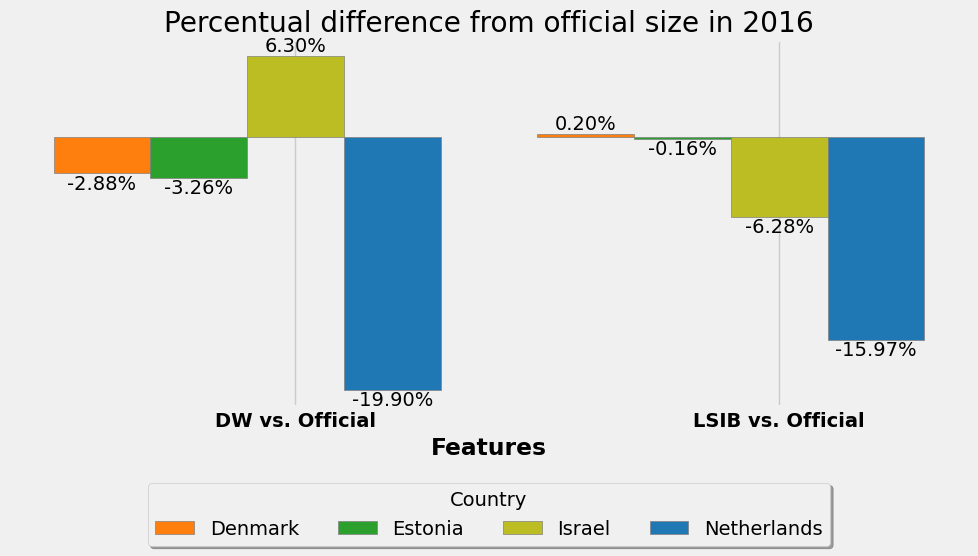

In [23]:
import matplotlib.pyplot as plt
from config import COUNTRY_COLORS

plt.style.use("fivethirtyeight")

# Assuming data_2016 is already loaded and sorted as necessary
fig, ax = plt.subplots(figsize=(10, 6))

barWidth = 0.05

# Define the features and the number of groups
features = [
    "DW vs. Official",
    "LSIB vs. Official",
]
num_features = len(features)
num_countries = len(data_2016["area"].unique())
group_width = num_countries * barWidth

# Calculate positions for groups centered around feature ticks
group_pos = [x * (group_width + barWidth) for x in range(num_features)]

# Create a color palette
colors = COUNTRY_COLORS

# Plotting
for i, country in enumerate(sorted(data_2016["area"].unique())):
    # Offsets for each country within the group
    offsets = [x + (barWidth * i) for x in group_pos]

    # Extracting data for each country
    country_data = data_2016[data_2016["area"] == country]
    bars = [
        country_data["perc_DW_diff_from_official"].values[0],
        country_data["perc_LSIB_diff_from_official"].values[0],
    ]

    # Plot each bar for the current country
    rects = plt.bar(
        offsets,
        bars,
        color=colors[country],
        width=barWidth,
        edgecolor="grey",
        label=country,
    )

    # Add text labels on the bars
    for rect, label in zip(rects, bars):
        height = rect.get_height()
        # Determine position based on bar's value (positive or negative)
        if height < 0:
            label_position = height - 0.05  # Shift down for negative bars
            va = "top"
        else:
            label_position = height + 0.05  # Shift up for positive bars
            va = "bottom"
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            label_position,
            f"{label:.2f}%",
            ha="center",
            va=va,  # Use variable vertical alignment
        )

# Setting up labels and ticks
plt.xlabel("Features", fontweight="bold")
plt.xticks([r + group_width / 2 for r in group_pos], features, fontweight="bold")
plt.ylabel("Percentage difference from official size", fontweight="bold")

# hide the y-axis
plt.gca().axes.get_yaxis().set_visible(False)

plt.title("Percentual difference from official size in 2016")

# place the legend below the plot
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    shadow=True,
    ncol=4,
    title="Country",
    fontsize="medium",
)

plt.tight_layout()

outpath = EXAMPLE_ASSETS / "country_sizes.png"
print("Saving plot to ", outpath)
plt.savefig(outpath)

In [34]:
subset_data = data_2016[
    [
        "area",
        "DW Classified Area",
        "LSIB_size",
        "official_size",
        "perc_DW_diff_from_official",
        "perc_LSIB_diff_from_official",
    ]
]
# renmae columns
subset_data.rename(
    columns={
        "DW Classified Area": "DW Classified Area (km^2)",
        "LSIB_size": "LSIB Size (km^2)",
        "official_size": "Official Size (km^2)",
        "perc_DW_diff_from_official": "DW % Diff from Official",
        "perc_LSIB_diff_from_official": "LSIB % Diff from Official",
    },
    inplace=True,
)

# Theh following columns should be formatted in thousand with no decimals:
# DW Classified Area (km^2), LSIB Size (km^2), Official Size (km^2)
subset_data["DW Classified Area (km^2)"] = subset_data[
    "DW Classified Area (km^2)"
].apply(lambda x: f"{x:,.0f}")
subset_data["LSIB Size (km^2)"] = subset_data["LSIB Size (km^2)"].apply(
    lambda x: f"{x:,.0f}"
)
subset_data["Official Size (km^2)"] = subset_data["Official Size (km^2)"].apply(
    lambda x: f"{x:,.0f}"
)

# The following columns should be formatted in percentage with 1 decimals:
# DW % Diff from Official, LSIB % Diff from Official
subset_data["DW % Diff from Official"] = subset_data["DW % Diff from Official"].apply(
    lambda x: f"{x:.1f}%"
)
subset_data["LSIB % Diff from Official"] = subset_data[
    "LSIB % Diff from Official"
].apply(lambda x: f"{x:.1f}%")

# dort by area
subset_data.sort_values(by="area", inplace=True)


subset_data.to_latex(
    EXAMPLE_ASSETS / "country_sizes.tex",
    index=False,
    escape=False,
    column_format="lcccccc",
)

subset_data

,area,DW Classified Area (km^2),LSIB Size (km^2),Official Size (km^2),DW % Diff from Official,LSIB % Diff from Official
0,Denmark,"41,715","43,036","42,952",-2.9%,0.2%
7,Estonia,"43,859","45,268","45,339",-3.3%,-0.2%
14,Israel,"23,540","20,755","22,145",6.3%,-6.3%
15,Netherlands,"33,520","35,166","41,850",-19.9%,-16.0%


## How precise is the cropland area estimation?

Vi kan kigge på grassland sammen med cropland. Er det ikke hvert 5 år at crop=grassland? I så fald kan vi vel tage 1/5 af grassland og lægge til cropland.

# How precise is the SAtlas Solar Classification?

The SAtlas Solar Classification is a classification of the land cover based on the solar panel density. The information is from [SAtlas Github](https://github.com/allenai/satlas/blob/main/GeospatialDataProducts.md) and the data can be downloaded from [here](https://pub-956f3eb0f5974f37b9228e0a62f449bf.r2.dev/outputs/renewable/latest_solar.shp.zip)

### These are the locations of the solar panels in the SAtlas Solar Classification

In [3]:
DK_shape, SAtlas = load_SAtlas_Solar_Classification_Data()
SAtlas = SAtlas.to_crs(epsg=EPSG_MAPPING["Plotting"])

# Create a Folium map object
m = folium.Map(
    location=[
        SAtlas.geometry.centroid.y.mean(),
        SAtlas.geometry.centroid.x.mean(),
    ],
    zoom_start=12,
)
# add the solar panels to the map
for idx, row in SAtlas.iterrows():
    folium.GeoJson(row.geometry).add_to(m)

m

Initializing Earth Engine with Viktor's project
['12_14_7']


### These are the locations of the solar panels from Energistyrelsen

In [4]:
energistyrelsen = load_Energistyrelsen_data()

m = folium.Map(
    location=[
        energistyrelsen.latitude.mean(),
        energistyrelsen.longitude.mean(),
    ],
    zoom_start=12,
)
for idx, row in energistyrelsen.iterrows():
    lat, lon = row["latitude"], row["longitude"]

    if pd.isna(lat) or pd.isna(lon):
        continue

    folium.Marker(
        location=[lat, lon],
        popup=f"{lat}, {lon}",
    ).add_to(m)

m

### Verifying 

We're are verifying the correctness of the SAtlas Solar Classification by comparing the solar panel locations with the solar panel locations from the Energistyrelsen.

In [5]:
# Remove empty Points
energistyrelsen = energistyrelsen[~energistyrelsen.geometry.is_empty]

SAtlas["centroid"] = SAtlas.geometry.centroid
dist_df = pd.DataFrame()

for idx, row in SAtlas.iterrows():
    for idx2, row2 in energistyrelsen.iterrows():
        sx, sy = row["centroid"].x, row["centroid"].y
        ex, ey = row2["geometry"].x, row2["geometry"].y
        distance = geodesic((sx, sy), (ex, ey)).kilometers
        dist_df = pd.concat(
            [
                dist_df,
                pd.DataFrame(
                    {
                        "SAtlas_index": [idx],
                        "Energistyrelsen_index": [idx2],
                        "distance": [distance],
                        "satlas_cords": [row["centroid"]],
                        "energistyrelsen_cords": [row2["geometry"]],
                    },
                ),
            ]
        )

df = dist_df.copy()

df.sort_values("distance", inplace=True)

# Create a list to store the results
results = []
# Create a set to store the used indexes
used_satlas_indexes = set()
used_energistyrelsen_indexes = set()

# Iterate over the rows in the distance dataframe
for idx, row in df.iterrows():
    # Check if the SAtlas index has been used
    if row["SAtlas_index"] in used_satlas_indexes:
        continue
    # Check if the Energistyrelsen index has been used
    if row["Energistyrelsen_index"] in used_energistyrelsen_indexes:
        continue

    # Add the indexes to the used sets
    used_satlas_indexes.add(row["SAtlas_index"])
    used_energistyrelsen_indexes.add(row["Energistyrelsen_index"])

    # Add the result to the results list
    results.append(
        {
            "SAtlas_index": row["SAtlas_index"],
            "Energistyrelsen_index": row["Energistyrelsen_index"],
            "Distance": row["distance"],
        }
    )

# Create a dataframe from the results list
result_df = pd.DataFrame(results)

### How many of the locations from the SAtlas Solar Classification are also in the Energistyrelsen data?

In [6]:
# How many of the locations from the SAtlas Solar Classification are also in the Energistyrelsen data?
percent = (
    len(set(SAtlas.index).intersection(used_satlas_indexes)) / len(SAtlas.index) * 100
)
print(
    f"{percent:.2f}% of the SAtlas Solar Classification locations are also in the Energistyrelsen data"
)

34.32% of the SAtlas Solar Classification locations are also in the Energistyrelsen data


### How close are the locations from the SAtlas Solar Classification to the locations from the Energistyrelsen data?

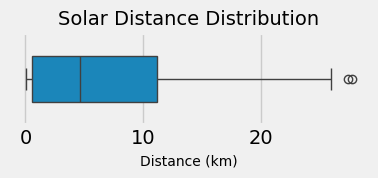

In [25]:
# Make the background transparent

plt.figure(figsize=(4, 2))


plt.style.use("fivethirtyeight")


sns.boxplot(
    data=result_df["Distance"],
    orient="h",
    width=0.5,
)

# change font size of xlabel
plt.xlabel("Distance (km)", fontsize=10)

# change font size of title
plt.title("Solar Distance Distribution", fontsize=14)


# save to file
outpath = EXAMPLE_ASSETS / "Solar-Verification-Distances.png"
plt.tight_layout()
plt.savefig(
    outpath,
    transparent=True,
)

### What are the two points furthest apart?

In [17]:
# plot the two points furthest apart
max_distance = result_df["Distance"].max()
max_distance_row = result_df[result_df["Distance"] == max_distance].iloc[0]

s_row = SAtlas.loc[max_distance_row["SAtlas_index"]]
e_row = energistyrelsen.loc[max_distance_row["Energistyrelsen_index"]]

m = folium.Map(
    location=[
        s_row.geometry.centroid.y,
        s_row.geometry.centroid.x,
    ],
    zoom_start=12,
)

folium.GeoJson(s_row.geometry).add_to(m)
folium.Marker(
    location=[e_row["latitude"], e_row["longitude"]],
    popup=f"{e_row['latitude']}, {e_row['longitude']}",
).add_to(m)

m

# Crop Verification

In [18]:
from sys import path
from IPython.display import IFrame

path.append("..")
from src.verify_DW_crops import (
    read_verification_results,
    plot_tabular_data,
    plot_misclassified_croplands_map,
)
import matplotlib.pyplot as plt

In [19]:
year = 2016
table, gdf = read_verification_results(year)

FileNotFoundError: [Errno 2] No such file or directory: '../output/verification/intersecting_areas_2016.csv'

In [20]:
metrics = ["area", "percent"]

plot_tabular_data(table, year, metric=metrics[0])

NameError: name 'table' is not defined

In [21]:
m = plot_misclassified_croplands_map(gdf, year)
m

NameError: name 'gdf' is not defined

# Wind Turbines
## Show amount of simple distnace matches
## Show boxplot of distance to nearest match
## Show correctly classified area under assumptions

In [4]:
from sys import path

path.append("..")
from src.verify_SATLAS_wind import main as verify_SATLAS_wind, plot_row, plot_threshold

In [5]:
merged_frame, wind_turbines = verify_SATLAS_wind()

/Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/src/data_handlers.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moeller.loc[moeller["Dato for afmeldning"].isna()]["ACTIVE"] = True
/Users/askemeineche/Documents/ITU/MasterThesis/Project/thesis/src/data_handlers.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moeller.loc[moeller["Type af placering"] == "Land"]["Type af placering"] = "LAND"
10620it [03:38, 48.63it/s]
8245it [00:25, 320.43it/s]


In [6]:
merged_frame.head()

,Møllenummer (GSRN),Kapacitet (kW),Rotor-diameter (m),geometry,name,year,area,data_origins,centroid_ENS,index_right,object_id,geometries,distance
2,570714700000000027,225.0,27.0,"POLYGON ((12.50977 55.63630, 12.50979 55.63630...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (12.50977 55.63618),511,-5288157881548453981,"POLYGON ((12.13851 55.67533, 12.13858 55.67531...",23781.775893
3,570714700000000034,225.0,27.0,"POLYGON ((12.51131 55.63672, 12.51133 55.63672...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (12.51131 55.63660),511,-5288157881548453981,"POLYGON ((12.13851 55.67533, 12.13858 55.67531...",23868.871414
4,570714700000000041,600.0,44.0,"POLYGON ((12.62041 55.69799, 12.62044 55.69799...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (12.62041 55.69779),18430,3608048101048861449,"POLYGON ((12.31697 55.84154, 12.31679 55.84145...",25033.177130
5,570714700000000058,600.0,44.0,"POLYGON ((12.62237 55.69785, 12.62240 55.69785...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (12.62237 55.69765),18430,3608048101048861449,"POLYGON ((12.31697 55.84154, 12.31679 55.84145...",25137.575831
6,570714700000000065,600.0,44.0,"POLYGON ((12.62538 55.69770, 12.62542 55.69769...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (12.62538 55.69750),18430,3608048101048861449,"POLYGON ((12.31697 55.84154, 12.31679 55.84145...",25293.774938


In [8]:
merged_frame.sort_values("distance").he

,Møllenummer (GSRN),Kapacitet (kW),Rotor-diameter (m),geometry,name,year,area,data_origins,centroid_ENS,index_right,object_id,geometries,distance
6746,570715000000059414,1300.0,62.0,"POLYGON ((8.67767 55.40552, 8.67771 55.40552, ...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (8.67767 55.40524),8430,-2009448117258985908,"POLYGON ((8.67862 55.40442, 8.67847 55.40437, ...",0.796850
4740,570715000000035722,500.0,37.0,"POLYGON ((8.52746 55.46204, 8.52749 55.46204, ...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (8.52746 55.46188),5489,-3115623959307385883,"POLYGON ((8.52651 55.46058, 8.52636 55.46062, ...",0.850884
2372,570715000000010033,600.0,44.0,"POLYGON ((9.32516 56.74041, 9.32520 56.74041, ...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (9.32516 56.74021),5918,-61955859252082336,"POLYGON ((9.32590 56.74154, 9.32614 56.74149, ...",0.910661
4596,570715000000034176,600.0,44.0,"POLYGON ((8.47553 55.76117, 8.47556 55.76117, ...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (8.47553 55.76097),537,793435996638417665,"POLYGON ((8.47577 55.76143, 8.47584 55.76141, ...",0.917345
8390,570715000001443731,3200.0,113.0,"POLYGON ((9.15257 57.06429, 9.15266 57.06429, ...",Wind Turbine,2016,Denmark,Energistyrelsen,POINT (9.15257 57.06378),2626,4870061634139866484,"POLYGON ((9.15339 57.06393, 9.15341 57.06388, ...",1.131215


array([[<Axes: title={'center': 'distance'}>]], dtype=object)

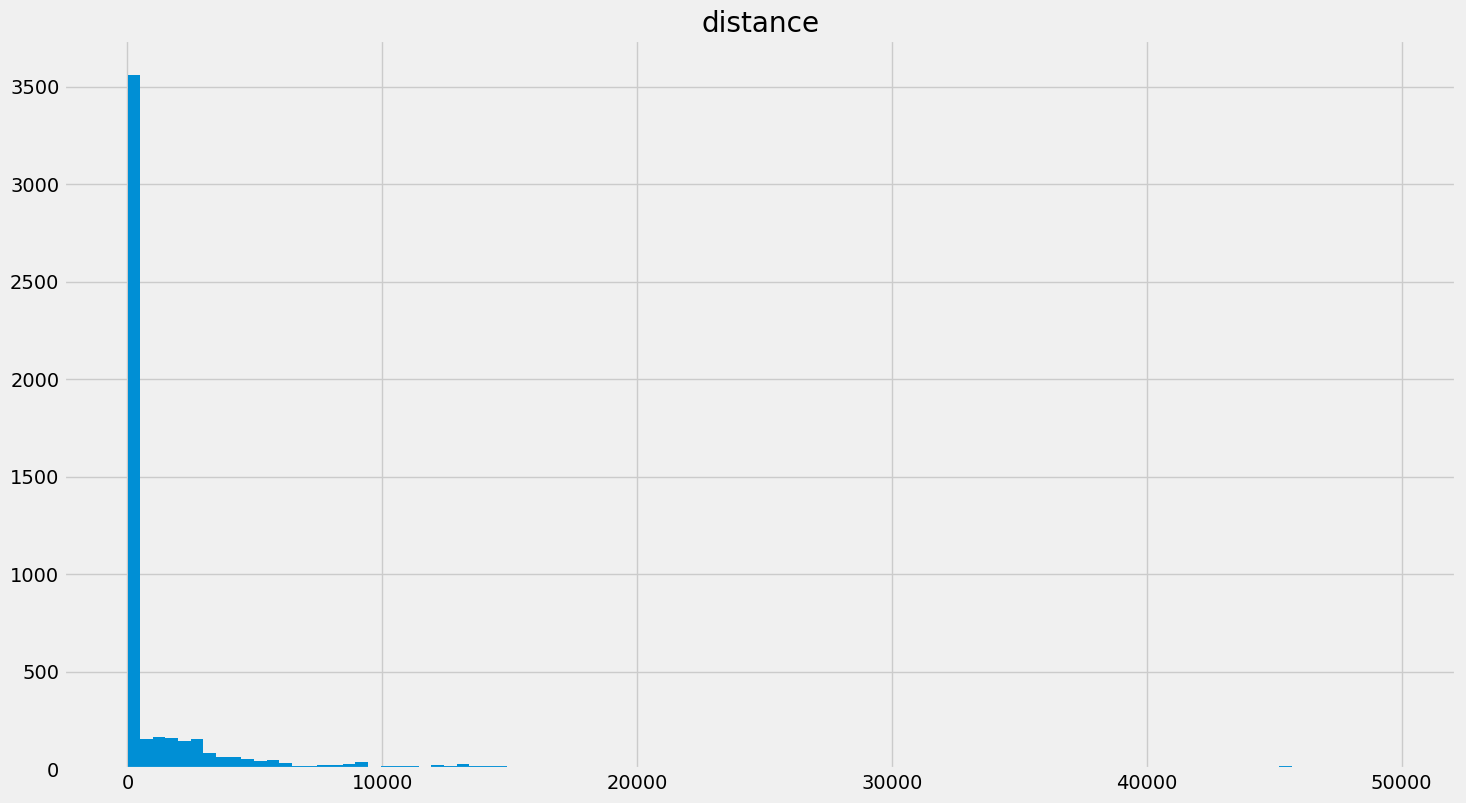

In [12]:
plt.style.use("fivethirtyeight")
frame = (
    merged_frame[["Møllenummer (GSRN)", "distance"]]
    .groupby("Møllenummer (GSRN)")
    .min()
    .reset_index()
)
frame.sort_values("distance").hist(bins=100, figsize=(16, 9))

<Axes: >

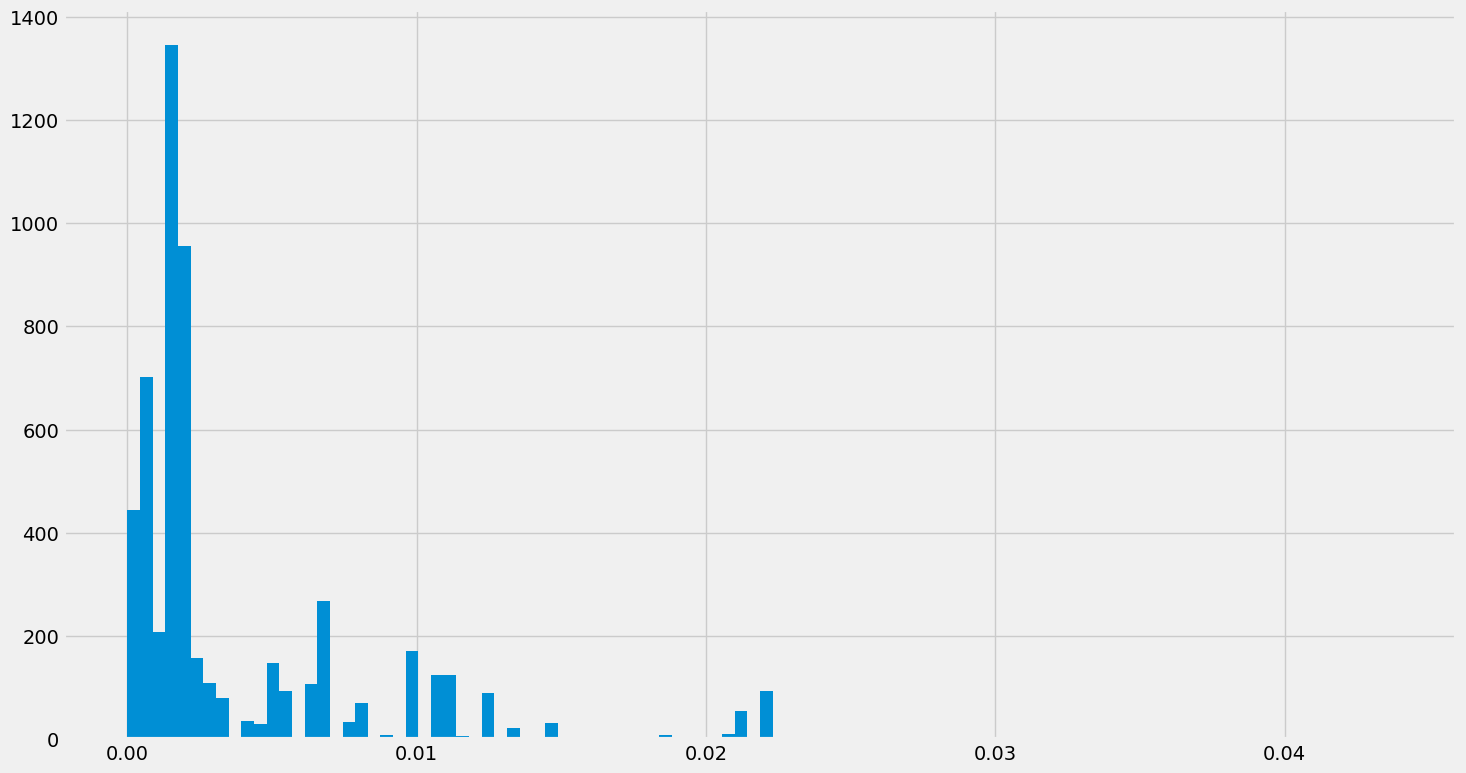

In [34]:
# calculate the area of each row as the area of a circle with diameter of 'Rotor-diameter (m)'
import math

merged_frame["area"] = (merged_frame["Rotor-diameter (m)"] / 2) ** 2 * math.pi / 10**6
merged_frame["area"].hist(bins=100, figsize=(16, 9))

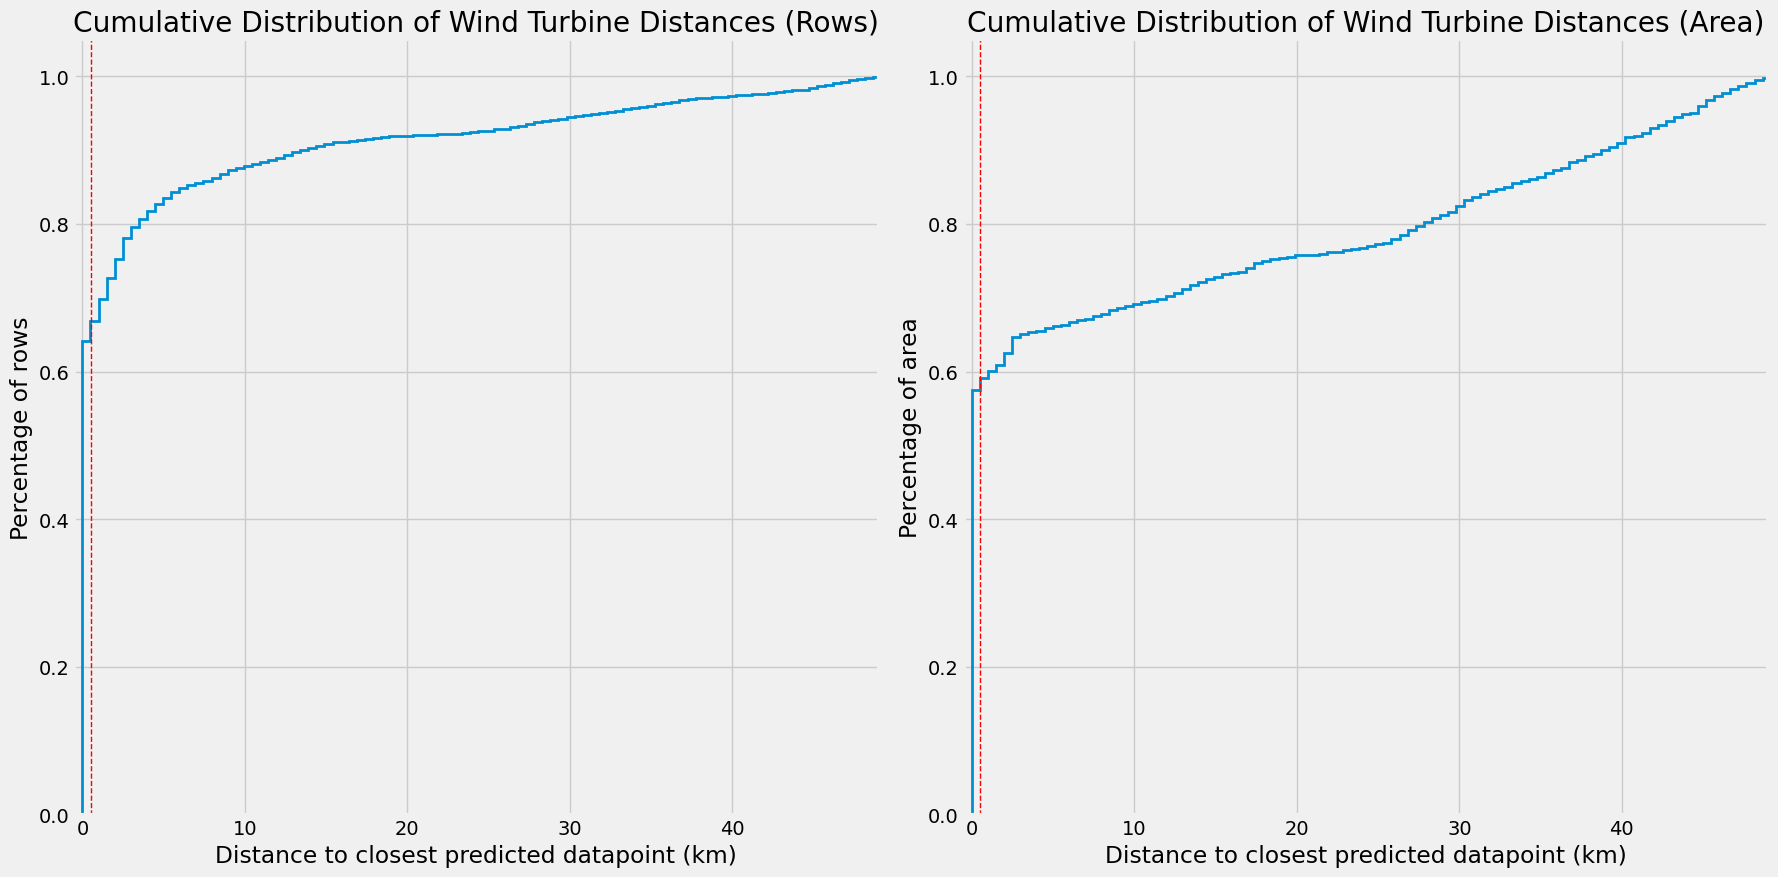

In [37]:
import matplotlib.pyplot as plt

# please make a wider margin between the two plots

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))

# First subplot
axes[0].hist(
    frame["distance"] / 1000,
    bins=100,
    cumulative=True,
    density=True,
    histtype="step",
    linewidth=2,
)
axes[0].set_xlabel("Distance to closest predicted datapoint (km)")
axes[0].set_ylabel("Percentage of rows")
axes[0].axvline(0.5, color="red", linestyle="--", linewidth=1)
axes[0].set_xlim(-0.5, 49)
axes[0].set_title("Cumulative Distribution of Wind Turbine Distances (Rows)")

# Second subplot
axes[1].hist(
    merged_frame["distance"] / 1000,
    bins=100,
    cumulative=True,
    density=True,
    histtype="step",
    linewidth=2,
    weights=merged_frame["area"],
)
axes[1].set_xlabel("Distance to closest predicted datapoint (km)")
axes[1].set_ylabel("Percentage of area")
axes[1].axvline(0.5, color="red", linestyle="--", linewidth=1)
axes[1].set_xlim(-0.5, 49)
axes[1].set_title("Cumulative Distribution of Wind Turbine Distances (Area)")

# Adjust layout to prevent overlap
fig.tight_layout()

# Show the plots
plt.show()

Text(0.5, 1.0, 'Cumulative Distribution of Wind Turbine Distances')

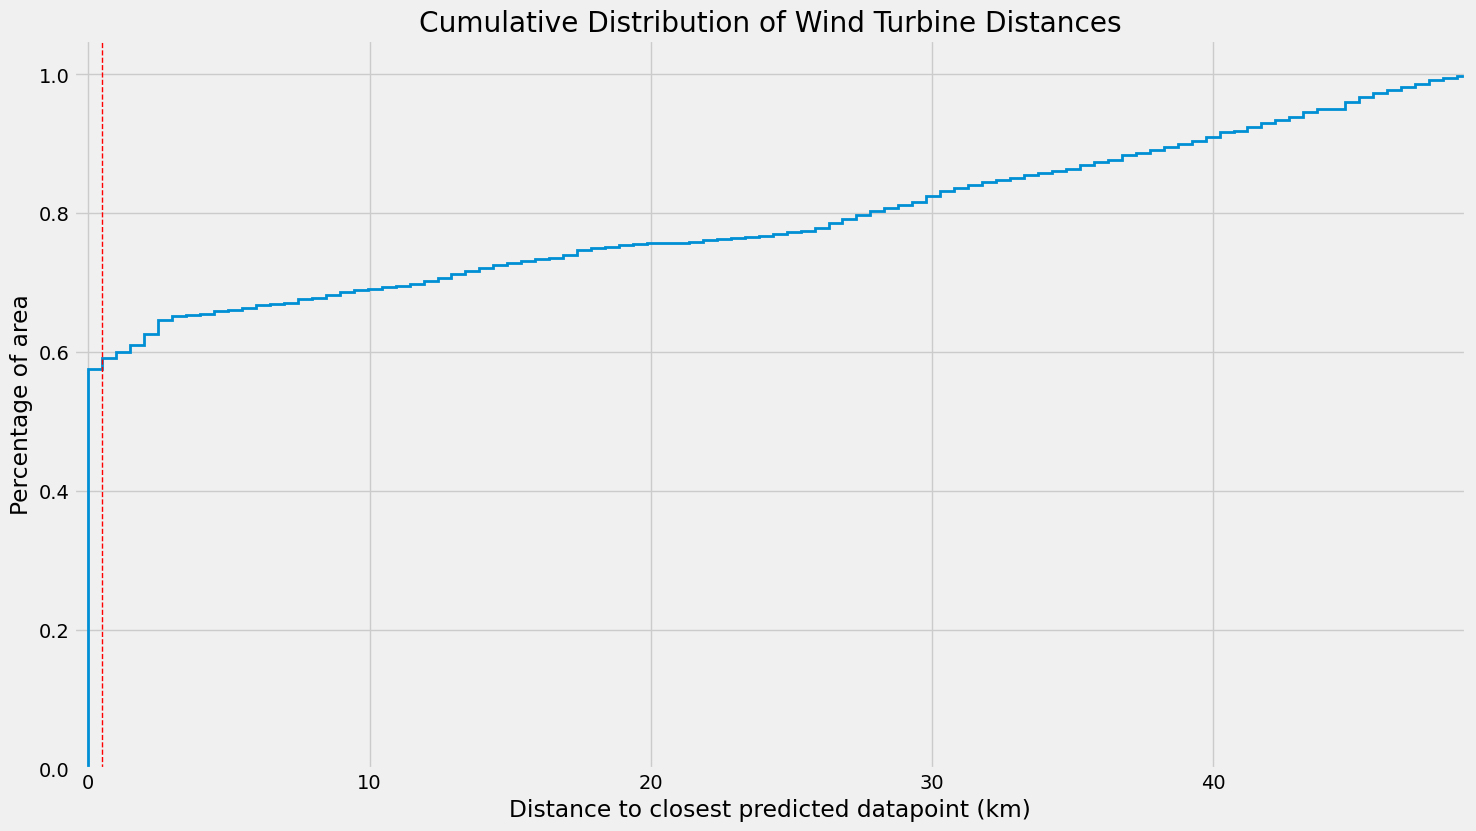

In [35]:
# create a cummulative plot with matplotlib displaying the percentage of area within a certain distance
plt.figure(figsize=(16, 9))
plt.hist(
    merged_frame["distance"] / 1000,
    bins=100,
    cumulative=True,
    density=True,
    histtype="step",
    linewidth=2,
    weights=merged_frame["area"],
)
plt.xlabel("Distance to closest predicted datapoint (km)")
plt.ylabel("Percentage of area")
# create a dashed red vertical line at x = 0.5

plt.axvline(0.5, color="red", linestyle="--", linewidth=1)
plt.xlim(-0.5, 49)
plt.title("Cumulative Distribution of Wind Turbine Distances")

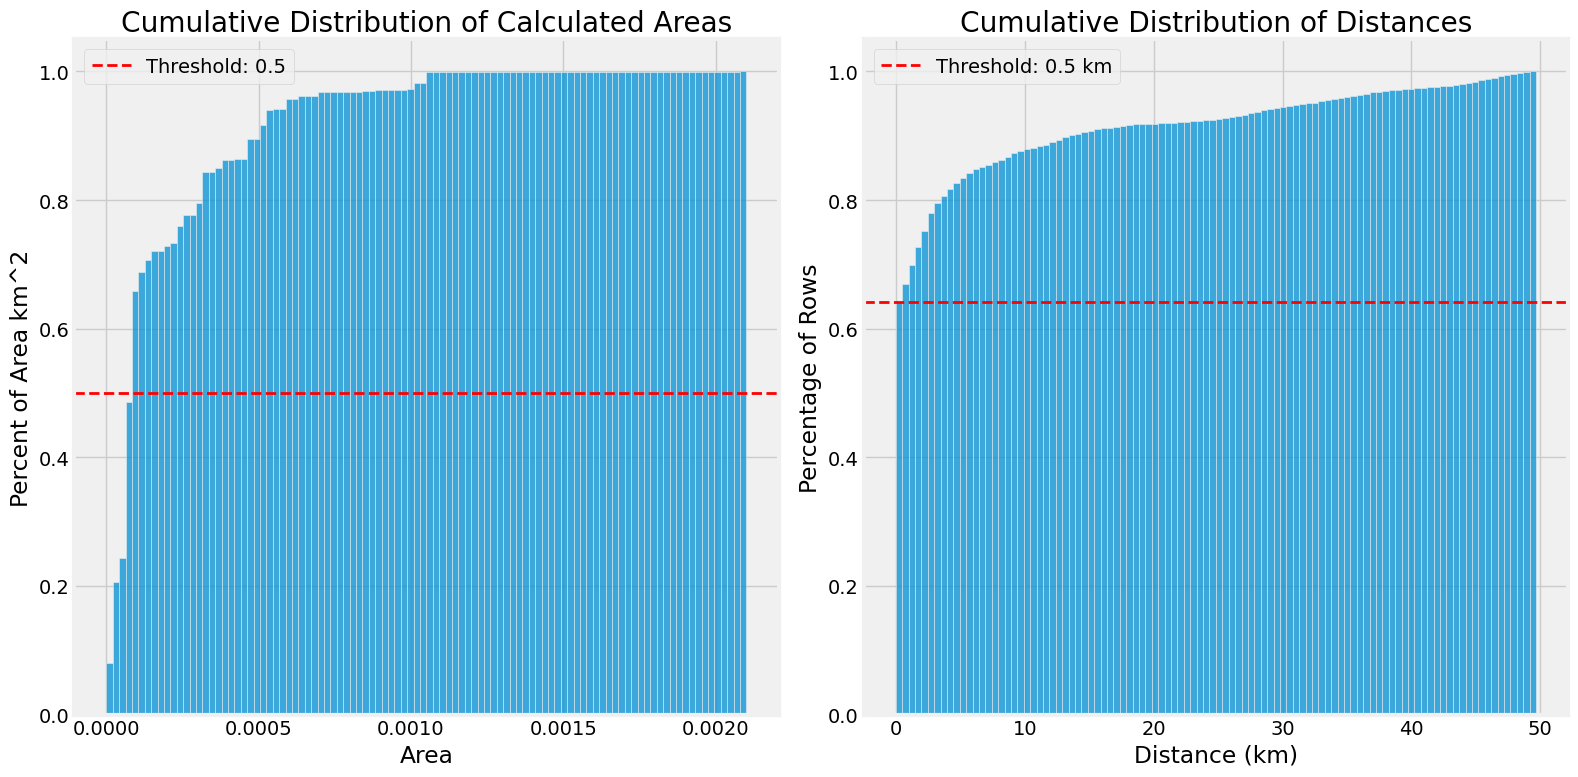

In [ ]:
plot_threshold(merged_frame, wind_turbines)

In [ ]:
plot_row(merged_frame, IX=3000)

# How much solar do we miss based on because of the Wind Solar assumption?

In [1]:
from src.DataBaseManager import DBMS
from config import EXAMPLE_VERIFICATION_FILES
import pandas as pd

filename = EXAMPLE_VERIFICATION_FILES / "solar_wind_overlap.csv"

if filename.exists():
    df = pd.read_csv(filename)
else:
    dbms = DBMS()
    df = dbms.read(query_name="GET_SOLAR_WIND_OVERLAP", params={})
    df.to_csv(filename, index=False)

df["year"] = pd.to_datetime(df["year"])
df["year"] = df["year"].dt.year

"""
Feature explanation:
- yearly_overlap_km2 : intersection mellem sol og vind
- wind_turbine_km2 : 
- solar_panel_km2 : 
- percentage_of_wind_turbine_area : overlap / total vind
- percentage_of_solar_panel_area : overlap / total sol
- percentage_of_renewable_area : overlap / (total vind + total sol)
"""

df

,area,year,yearly_overlap_km2,wind_turbine_km2,solar_panel_km2,percentage_of_wind_turbine_area,percentage_of_solar_panel_area,percentage_of_renewable_area
0,Denmark,2017,0.008507,103.048598,7.469014,0.008255,0.113891,0.007697
1,Denmark,2018,0.019480,151.368445,9.580022,0.012869,0.203342,0.012103
2,Denmark,2019,0.035396,68.497218,10.746661,0.051675,0.329367,0.044667
3,Denmark,2020,0.090919,151.533876,13.113031,0.059999,0.693347,0.055220
4,Denmark,2021,0.863518,221.482428,19.758301,0.389881,4.370409,0.357949
5,Denmark,2022,0.808598,190.416601,27.178956,0.424647,2.975089,0.371606
6,Denmark,2023,0.992988,230.891469,27.221868,0.430067,3.647760,0.384710
7,Netherlands,2018,0.015921,39.383728,6.314981,0.040425,0.252110,0.034838
8,Netherlands,2019,0.004902,18.613315,11.598707,0.026335,0.042261,0.016224
9,Netherlands,2020,0.017623,46.074545,21.388888,0.038249,0.082394,0.026123


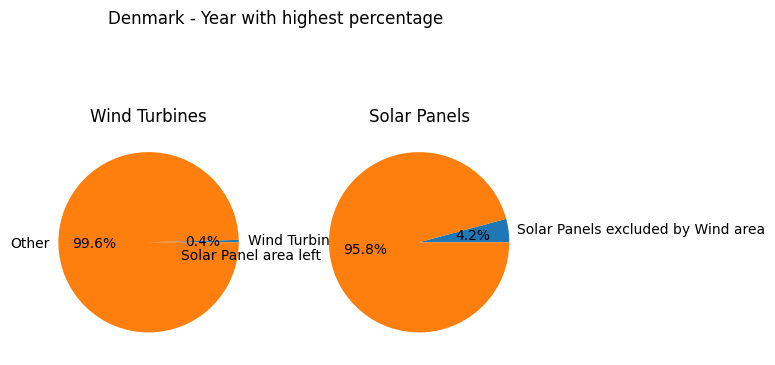

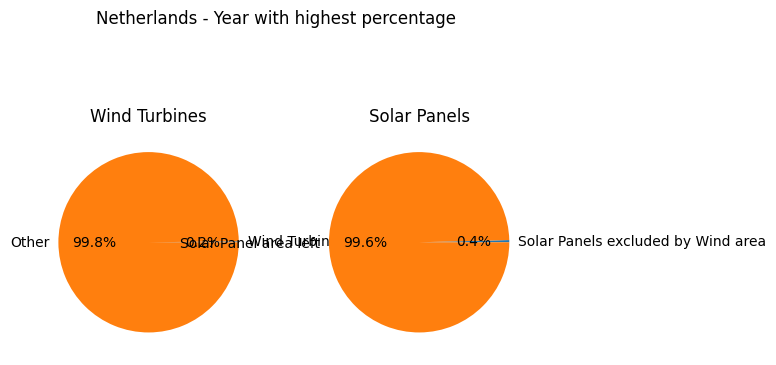

In [ ]:
import matplotlib.pyplot as plt

countries = df["area"].unique()

for country in countries:
    country_df = df[df["area"] == country]

    # find the year with the highest percentage in both percentage_of_wind_turbine_area and percentage_of_solar_panel_area
    max_wind = country_df["percentage_of_wind_turbine_area"].idxmax()
    max_solar = country_df["percentage_of_solar_panel_area"].idxmax()

    # Create two pie charts where it shows the percentage of wind turbines and solar panels in the year with the highest percentage
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"{country} - Year with highest percentage")
    axs[0].pie(
        [country_df.loc[max_wind, "percentage_of_wind_turbine_area"], 100],
        labels=[
            "Wind Turbines",
            "Other",
        ],
        autopct="%1.1f%%",
    )
    axs[0].set_title("Wind Turbines")

    axs[1].pie(
        [country_df.loc[max_solar, "percentage_of_solar_panel_area"], 100],
        labels=[
            "Solar Panels excluded by Wind area",
            "Solar Panel area left",
        ],
        autopct="%1.1f%%",
    )
    axs[1].set_title("Solar Panels")

    plt.show()

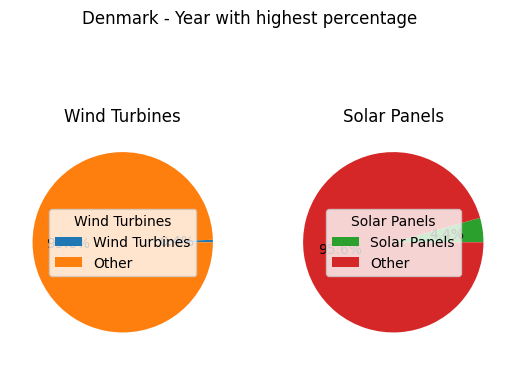

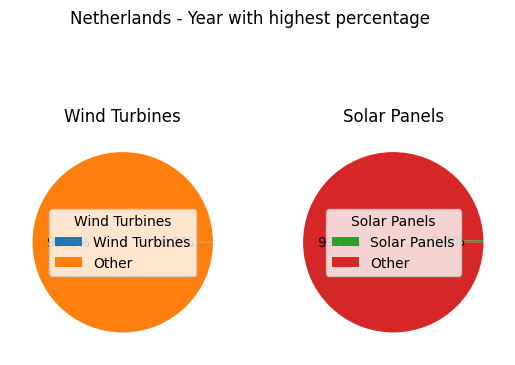

In [ ]:
import matplotlib.pyplot as plt

countries = df["area"].unique()

for country in countries:
    country_df = df[df["area"] == country]

    # Find the year with the highest percentage in both percentage_of_wind_turbine_area and percentage_of_solar_panel_area
    max_wind = country_df["percentage_of_wind_turbine_area"].idxmax()
    max_solar = country_df["percentage_of_solar_panel_area"].idxmax()

    # Create two pie charts where it shows the percentage of wind turbines and solar panels in the year with the highest percentage
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(f"{country} - Year with highest percentage")

    # Wind Turbines pie chart
    wind_data = [
        country_df.loc[max_wind, "percentage_of_wind_turbine_area"],
        100 - country_df.loc[max_wind, "percentage_of_wind_turbine_area"],
    ]
    axs[0].pie(
        wind_data,
        autopct="%1.1f%%",
        colors=["#1f77b4", "#ff7f0e"],  # Example colors, can be adjusted or omitted
    )
    axs[0].set_title("Wind Turbines")
    axs[0].legend(["Wind Turbines", "Other"], title="Wind Turbines")

    # Solar Panels pie chart
    solar_data = [
        country_df.loc[max_solar, "percentage_of_solar_panel_area"],
        100 - country_df.loc[max_solar, "percentage_of_solar_panel_area"],
    ]
    axs[1].pie(
        solar_data,
        autopct="%1.1f%%",
        colors=["#2ca02c", "#d62728"],  # Example colors, can be adjusted or omitted
    )
    axs[1].set_title("Solar Panels")
    axs[1].legend(["Solar Panels", "Other"], title="Solar Panels")

    plt.show()